# 21M.387 Fundamentals of Music Processing
## Problem Set 6: Chord Recognition

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

The data loaded below contains binary chord templates for four chords, arranged as a $4 \times 12$ matrix.

Identify each of the four chords. Visualizing this matrix with `plt.imshow()` can be useful.

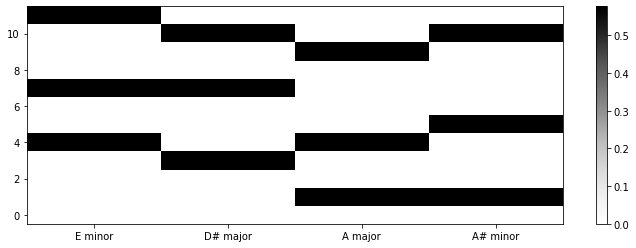

In [2]:
some_chords = np.load('data/ex1.npy')

c_names = ['E minor', 'D# major', 'A major', 'A# minor']
# for i in range(len(c_names)):
#     c = some_chords[i,:]
#     chord = list(np.where(c > 0)[0])
#     name = c_names[i]
#     print(f'{chord} ({name})')

plt.imshow(np.atleast_2d(some_chords).T, origin='lower', aspect='auto', cmap='Greys')
plt.xticks(np.arange(some_chords.shape[0]), ['E minor', 'D# major', 'A major', 'A# minor'])
plt.colorbar()
plt.show()

## Exercise 2

In the following example, a simple template-based chord classifier is estimating chords in Bach's first prelude of the _Well-Tempered-Clavier_. The colored labels are as follows:
- TP: True Positive - the algorithm picked the correct chord
- FN: False Negative - shows the chord that should have been picked, but wasn't
- FP: False Positive - shows the incorrect chord that the algorithm picked 

<img src="images/bach_evaluation.png" width=700>

The algorithm is doing a good job in bars 1 and 4, but making more mistakes in bars 2 and 3. Why is this the case?

Answer:

Bars 1 and 4 have a "pure" triad (C major), while bars 2 and 3 have extra notes that might be throwing off the classifier. E.g., on bar 2 the D minor has an extra C (left hand), and the G major on bar 3 has an extra F on the right hand.

## Exercise 3

Write the function `make_triads_templates()` to produce $\mathcal{T}_h$, a harmonics chords template matrix with 24 rows where each row is a chord template:
- rows $[0-11]$ are the major triads (starting with __C__)
- rows $[12-23]$ are the minor triads (starting with __Cm__)

Inputs: 
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates.

Output:
- $\mathcal{T}_h$, the $24 \times 12$ harmonic chord templates matrix for all major and minor triads

For this exercise, you can use `fmp.harmonics_chord_template()`.

Test your function with $\alpha = 0.6$ and plot the resulting matrix with `plt.imshow()`.

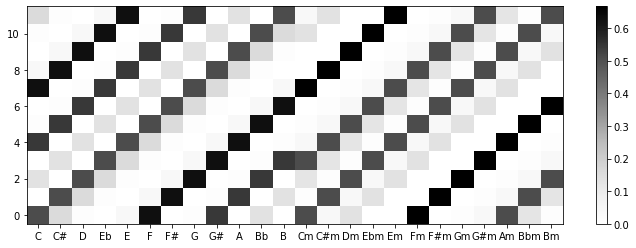

In [3]:
def make_triads_templates(alpha) :
    c_maj = [0, 4, 7]
    c_min = [0, 3, 7]
    maj_triads = np.array([[(i + j) % 12 for j in c_maj] for i in range(12)])
    min_triads = np.array([[(i + j) % 12 for j in c_min] for i in range(12)])
    triads = np.concatenate((maj_triads, min_triads))
    
    ts = np.zeros((24, 12))
    for i, t in enumerate(triads):
        ts[i] = fmp.harmonics_chord_template(t, alpha)
    
    return ts
    
# plot your result:
ts = make_triads_templates(0.6)
plt.imshow(np.atleast_2d(ts).T, origin='lower', aspect='auto', cmap='Greys')
cs = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
plt.xticks(np.arange(ts.shape[0]), [str(c) for c in cs] + [str(c) + 'm' for c in cs])
plt.colorbar()
plt.show()

# fmplib:
# ts = fmp.make_triads_templates(0.6)
# plt.imshow(np.atleast_2d(ts).T, origin='lower', aspect='auto', cmap='Greys')
# cs = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
# plt.xticks(np.arange(ts.shape[0]), [str(c) for c in cs] + [str(c) + 'm' for c in cs])
# plt.colorbar()
# plt.show()

## Exercise 4

Write the function `estimate_chords()` to produce an array of chord estimates given a song's chromagram using the template method described in lecture. 

Inputs:
- `chroma`: $\mathbf{C}$, the chromagram 
- `alpha`: $\alpha$, the parameter for creating the harmonic chord templates $\mathcal{T}_h$

Output:
- $\lambda^{\text{est}}[n]$, a vector of the same length as $\mathbf{C}$, containing index values $[0:24)$ of the most likely chord.

In [4]:
def estimate_chords(chroma, alpha):
    ts = make_triads_templates(alpha)
    est = np.dot(ts, chroma)

    return np.argmax(est, axis=0)

Estimate the chords of the first 51 seconds of _Here Comes the Sun_ by The Beatles using this function.

- Create a normalized chromagram using $N=4096, H=2048, \gamma=1$ using `fmp.make_chromagram()`.
- Estimate the chords, storing results in `ex4_est`
- Plot the chromagram (in its own figure)
- Plot `ex4_est` with a red dot at each point, using 'ro', in its own figure.

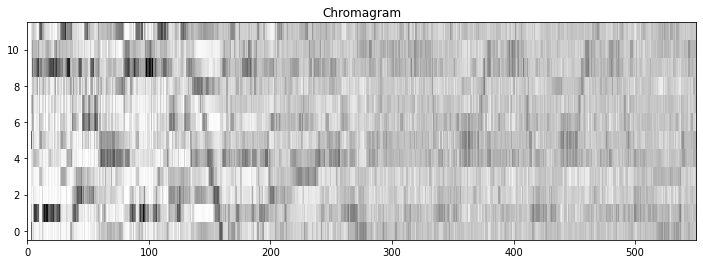

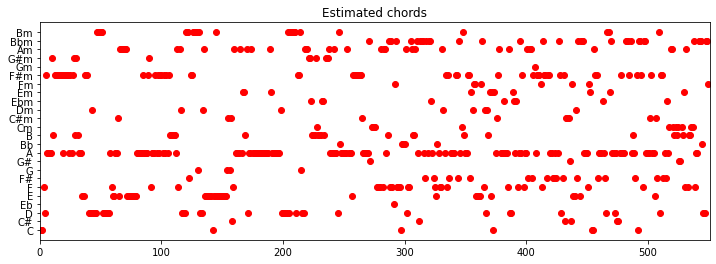

In [5]:
snd = fmp.load_wav("audio/beatles_here_comes_the_sun.wav",0, 51)
fs = 22050
display(ipd.Audio(snd, rate=fs))

fft_len = 4096
hop_size = fft_len // 2
gamma = 1.0
chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, normalize=True, gamma=gamma)
alpha = 0.6
ex4_est = estimate_chords(chroma, alpha)

# plots...
plt.rcParams['figure.figsize'] = (12, 4)
plt.title('Chromagram')
plt.imshow(chroma, origin='lower', aspect='auto', cmap='Greys')
plt.show()

plt.plot(ex4_est, 'ro')
plt.title('Estimated chords')
plt.xlim(0, ex4_est.shape[0])
fmp.chord_template_labels()  # assumed ok to use for plot styling
plt.show()

## Exercise 5

Write `calc_chord_score()`, a function to calculate the score for the estimated chords compared to the ground-truth reference annotated chords, as described in Lecture.

Inputs:
- `est`: $\lambda^{\text{est}}[n]$, the algorithmically generated chord estimate vector
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- a score value in the range $[0,1]$


Assume that $\lambda^{\text{est}}[n]$ and $\lambda^{\text{ref}}[n]$ are sampled at the same rate $F_f$. However, it is possible that they are not the same length.

The score is based on the common (overlapping) region between the two vectors, and also where  $\lambda^{\text{ref}}[n] \ne -1$. That is, ignore regions where no reference chord is annotated in calculating the score.


In [6]:
def calc_chord_score(est, ref):
    m = 0
    t = 0
    for i, c in enumerate(est): 
        if ref[i] == -1:
            continue
        t += 1            
        if c == ref[i]:
            m += 1

    return m / float(t)

Now calculate the score of the estimated chord of Exercise 4 using the reference annotations `"audio/beatles_here_comes_the_sun.lab"`, which you can load with `fmp.load_chord_annotations()`.

Call this score `ex5_score`.

In [7]:
ff = fs / hop_size
ex5_ref = fmp.load_chord_annotations("audio/beatles_here_comes_the_sun.lab", ff)
ex5_score = calc_chord_score(ex4_est, ex5_ref)

print(f'score: {ex5_score}')

# fmplib:
# c, t, s = fmp.get_score_stats(ex4_est, ex5_ref)
# print(f'correct={c}, total={t}, score={s}')

score: 0.31992687385740404


## Exercise 6

This score is quite poor. One reason is that The Beatles played this song with a tuning that is different from $A4=440$.

There is an optional parameter in `fmp.make_chromagram()` for providing a tuning value. This is normally 0, but can be used to adjust the tuning of the chromagram by fractional semitones. For example, passing in the argument `tuning = -0.2` will create a chromagram that works well for instruments playing 20 cents flat from $A4=440$. (Remember that 100 cents = 1 semitone).

Write the function `calc_chord_score_with_tuning()` that returns a score value, similarly to _Exercise 5_, but with a "tuned chromagram" (using the same parameters for $N, H, \gamma$). If you pass in a tuning value of 0, you should get same score as above.

Inputs:
- `snd`: the wave data
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector
- `tuning`: the tuning parameter for creating the chromagram, with values in the range $[-0.5, +0.5]$ representing a tuning of -50 cents to +50 cents.

Output:
- the score of the chord estimation

In [8]:
# NOTE: added chroma args needed for find_best_tuning method calls
def calc_chord_score_with_tuning(snd, ref, tuning,
                                 # new args:
                                 fs, fft_len, hop_size, gamma, alpha):
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, normalize=True,
                                 gamma=gamma, tuning=tuning)
    est = estimate_chords(chroma, alpha)
    score = calc_chord_score(est, ref)
    
    return score

Now try a bunch tuning values in the range $[-0.5, +0.5]$ and see what tuning value produces the best chord score. This value is the most likely tuning used in the original recording.

Write the function `find_best_tuning()` that returns the best tuning estimate.

Inputs:
- `snd`: the wave data
- `fs`: $F_s$, the sampling rate of `snd`
- `fft_size`, `hop_size`, `gamma`: parameters for creating the chromagram
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates.
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- the tuning parameter which maximizes the score of `calc_chord_score_with_tuning()`.

In [9]:
def find_best_tuning(snd, fs, fft_size, hop_size, gamma, alpha, ref):
    tunings = np.linspace(-0.5, 0.5, 51)
    ts = [calc_chord_score_with_tuning(snd, ref, t, fs, fft_len, 
                                       hop_size, gamma, alpha) for t in tunings]
    
    return tunings[np.argmax(tunings, axis=0)]

Using the same parameters for $N$, $H$, $\gamma$, and $\alpha$ as above, calculate and print the best tuning value (storing in `ex6_tuning`). Then, create:
- `ex6_chroma`, the properly tuned chromagram
- `ex6_est`, the estimated chords for this chromagram
- `ex6_score`, the score for these estimated chords

As above, plot `ex6_chroma` and `ex6_est`

best tuning=0.5, best score=0.5447897623400365


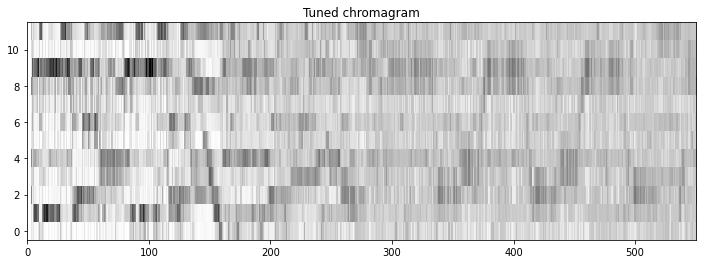

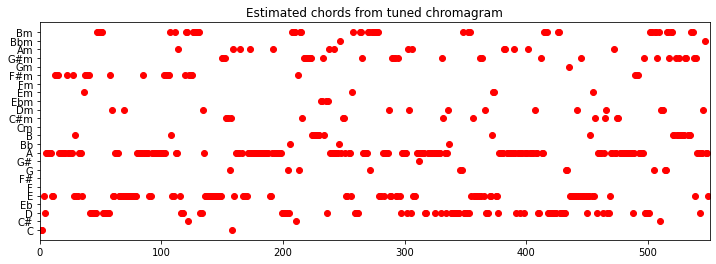

In [10]:
fft_len = 4096
hop_size = fft_len // 2
gamma = 1
alpha = 0.6

ex6_tuning = find_best_tuning(snd, fs, fft_len, hop_size, gamma, alpha, ex5_ref)
ex6_chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, normalize=True,
                                 gamma=gamma, tuning=ex6_tuning)
ex6_est = estimate_chords(ex6_chroma, alpha)
ex6_score = calc_chord_score(ex6_est, ex5_ref)

print(f'best tuning={ex6_tuning}, best score={ex6_score}')

# plots...
plt.rcParams['figure.figsize'] = (12, 4)
plt.title('Tuned chromagram')
plt.imshow(ex6_chroma, origin='lower', aspect='auto', cmap='Greys')
plt.show()

plt.plot(ex6_est, 'ro')
plt.title('Estimated chords from tuned chromagram')
plt.xlim(0, ex6_est.shape[0])
fmp.chord_template_labels()  # assumed ok to use for plot styling
plt.show()

## Exercise 7

We have seen examples of temporal smoothing (CENS chromagrams). Here you will create a function that applies temporal smoothing to all the rows of a matrix (like a chromagram).

Write the function `temporal_smoothing()` that applies a simple low-pass filter across each row of the input matrix.

Inputs:
- `mtx`: The input matrix
- `win_len`: $L$, the length of a rectangular window used to smooth the matrix

Output:
- A smoothed matrix of the same dimensions as `mtx`

For each row vector $x$ of the input matrix, create a smoothed version, $x^L$ by using `np.convolve()` to convolve $x$ with a rectangular window of length $L$ and amplitude $1/L$. It is the equivalent of performing the operation:

$$ x^L[n] = {1 \over L} \sum_{l=-L/2}^{L - L/2 - 1}x[n+l] $$

In other words, $x^L[n]$ just becomes the average value of its neighbors. To keep $x^L$ the same size as $x$, use the optional argument `mode='same'`.

In [11]:
def temporal_smoothing(mtx, win_len):
    w = np.full(win_len, 1 / float(win_len))

    x_L = np.zeros(mtx.shape)
    for i, row in enumerate(mtx):
        x_L[i] = np.convolve(row, w, mode='same')
        
    return x_L

# a = temporal_smoothing(ex6_chroma, 20)
# plt.rcParams['figure.figsize'] = (12, 4)
# plt.title('Smoothed + tuned chromagram')
# plt.imshow(a, origin='lower', aspect='auto', cmap='Greys')
# plt.show()

# b = fmp.temporal_smoothing(ex6_chroma, 20)
# plt.rcParams['figure.figsize'] = (12, 4)
# plt.title('Smoothed + tuned chromagram')
# plt.imshow(b, origin='lower', aspect='auto', cmap='Greys')
# plt.show()

Using `temporal_smoothing()`, write the function `find_best_smoothing_length()` that finds the best window length $L$ to maximize the chords estimation score by testing against different filtered chromagrams.

Inputs:
- `chroma`: $\mathbf{C}$, the chromagram
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- the optimal length $L$ which maximizes `calc_chord_score()` when filtering $\mathbf{C}$ with different lengths.

In [12]:
def find_best_smoothing_length(chroma, alpha, ref):
    win_lengths = np.arange(1, 101, 2) # odd values preferred
    best_s = 0
    best_w = 0
    for w in win_lengths:
        c = temporal_smoothing(chroma, w)
        est = estimate_chords(c, alpha)
        s = calc_chord_score(est, ex5_ref)
        if s > best_s:
            best_s = s
            best_w = w

    return best_w

Using the a properly tuned chromagram of _Here Comes the Sun_ from _Exercise 6_, calculate and print the best window length value (storing in `ex7_win_len`). Then, create:

- `ex7_chroma`, the smoothed chromagram using the optimal $L$
- `ex7_est`, the estimated chords for this chromagram
- `ex7_score`, the score for these estimated chords

As above, plot `ex7_chroma` and `ex7_est`

best length=11, best score=0.773308957952468


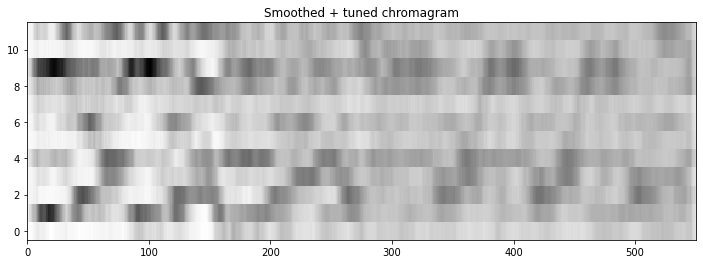

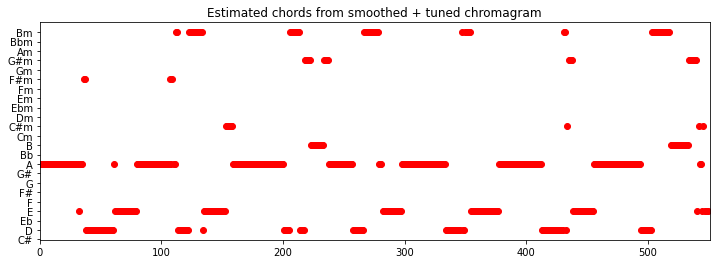

In [26]:
ex7_win_len = find_best_smoothing_length(ex6_chroma, alpha, ex5_ref)
ex7_chroma = temporal_smoothing(ex6_chroma, ex7_win_len)
ex7_est = estimate_chords(ex7_chroma, alpha)
ex7_score = calc_chord_score(ex7_est, ex5_ref)

print(f'best length={ex7_win_len}, best score={ex7_score}')

# plots...
plt.rcParams['figure.figsize'] = (12, 4)
plt.title('Smoothed + tuned chromagram')
plt.imshow(ex7_chroma, origin='lower', aspect='auto', cmap='Greys')
plt.show()

plt.plot(ex7_est, 'ro')
plt.title('Estimated chords from smoothed + tuned chromagram')
plt.xlim(0, ex7_est.shape[0])
fmp.chord_template_labels()  # assumed ok to use for plot styling
plt.show()

## Exercise 8

Write the function `generate_markov_sequence` to generate a random sequence of states.

Inputs:
- `init_p`: initial probabilities (vector $C$)
- `trans_p`: transition probs (matrix $A$)
- `length`: length of sequence to generate    

Output:
- an `np.array` (of type `int`) representing the state 

Strategy:

- First generate the initial state (based on $C$).  
- Then generate the rest of the states in a loop (based on $A$)

I recommend looking at the function `np.random.choice` and looking closely at the optional input parameter `p`.

In [76]:
def generate_markov_sequence(init_p, trans_p, length):
    seq = [np.random.choice(len(init_p), p=init_p)]
    curr_s = seq[0]
    
    for s in range(length-1):
        p = trans_p[curr_s]
        curr_s = np.random.choice(len(p), p=p)
        seq.append(curr_s)

    return seq

Generate a sequence of length 30 with the Markov parameters below.

Run this generating code multiple times. What do you notice about the sequences generated? Why does this happen?

**Answer**:
- First state is much more likely to be the starting state: 80% chance of getting picked.
- States are more likely to stay the same than to transition to another state: probability of 80% for first and second state, and 100% for third state.
- The sequence stays stuck on the third state once it is chosen. This is because the probability to transition out of it is set to 0, as the third row in $A$ is $(0, 0, 1.)$.

In [82]:
C = np.array((.8, .2, 0))
A = np.array(((.8, .2, 0), (.1, .8, .1), (0, 0, 1.)))

S1 = generate_markov_sequence(C, A, 30)
print(S1)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


## Exercise 9

There are three probability sets that need to be defined for an HMM model:
- $A$, the transition probabilities matrix for the hidden states
- $C$, the initial probabilities vector for the hidden states
- $B$, the emissions probabilities matrix that relate hidden states to observations

In this exercise, you will create these probability sets for the 24-chord model we have been using (12 major, 12 minor). Remember that probabilities must sum to one.

Write the function `make_trans_prob_matrix()` to create $A$. $A$ should have a large value on the diagonal (ie, self-transition probabilities) and small value everywhere else.

Inputs:
- `diag_ratio`: the diagonal-to-non-diagonal value (for example `diag_ratio=4` would have the diagonal values be 4x the other values).

Returns:
- $A$, the probability matrix.

Create and plot this matrix for a diagonal ratio of 3 (set as `trans_prob`). Use `plt.colorbar()` so you can graphically inspect the values.

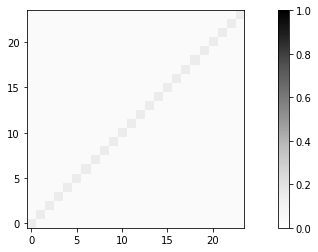

In [96]:
def make_trans_prob_matrix(diag_ratio):
    c = 24
    m = np.ones((c,c))
    d = np.eye(c) * (diag_ratio - 1) 
    m = m + d
    norm = np.linalg.norm(m, ord=1, axis=1).reshape((m.shape[0], 1))
    
    return m / norm


trans_prob = make_trans_prob_matrix(4)
#print(trans_prob[0])
# plot
plt.imshow(trans_prob, origin='lower', cmap="Greys", vmin=0, vmax=1)
plt.colorbar()
plt.show()

# fmplib:
# trans_prob = fmp.make_regular_transition_probs(4)
# print(trans_prob[0])
# plt.imshow(trans_prob, origin='lower', cmap="Greys", vmin=0, vmax=1)
# plt.colorbar()
# plt.show()

Write the function `make_init_prob_vector()` to create $C$ where the probability of starting on a major chord can differ from starting on a minor chord.

Inputs:
- `major_ratio`: the major-chord-to-minor-chord probability ratio (for example `major_ratio=4` would have major chords be 4x more likely than minor chords).

Returns:
- $C$, the initial probability vector.

Create and plot this vector for a major ratio of 3 (set as `init_prob`).

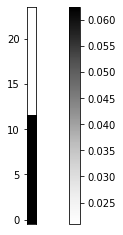

In [150]:
def make_init_prob_vector(major_ratio):
    c = 12
    maj_p = np.ones(c) * major_ratio
    min_p = np.ones(c)
    m = np.concatenate((maj_p, min_p))
    norm = float(np.sum(m))
    
    return m / norm

init_prob = make_init_prob_vector(3)

# plot
plt.imshow(np.atleast_2d(init_prob).T, origin='lower', cmap='Greys')
plt.colorbar()
plt.xticks([])
plt.show()

Write the function `make_emission_prob_matrix()` to create $B$ by taking advantage of our harmonics-based chord template. The relative chance of an observation (say $\mathbf{Am}$) being emitted from a particular state (say $\mathbf{C}$) can be represented as the dot product between  $\mathbf{Am}$'s template and $\mathbf{C}$'s template. The ratio of all these dot products is a good approximation for how likely it is for a state to produce an observation.

Inputs:
- `alpha`: $\alpha$, used to create the harmonic chord templates

Returns:
- $B$, the emissions probability matrix.

Create and plot this matrix for a $\alpha = 0.6$ (set as `emis_prob`).

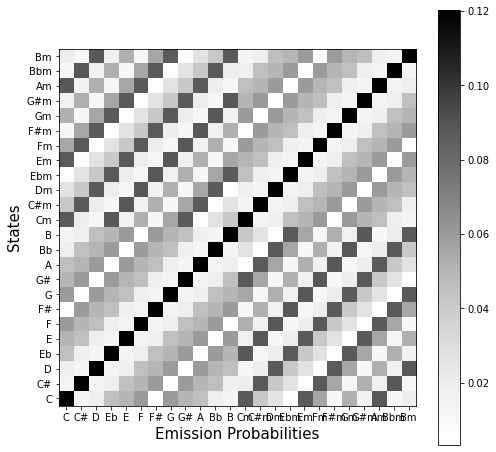

In [151]:
def make_emission_prob_matrix(alpha):
    ts = make_triads_templates(alpha)
    m = np.dot(ts, ts.T)
    norm = np.linalg.norm(m, ord=1, axis=1).reshape((m.shape[0], 1))
    
    return m / norm

emis_prob = make_emission_prob_matrix(0.6)

# plot
plt.figure(figsize=(8,8))
plt.imshow(emis_prob, origin='lower',cmap="Greys")
fmp.chord_template_labels(0)
fmp.chord_template_labels(1)
plt.colorbar();
plt.ylabel('States', fontsize=15)
plt.xlabel('Emission Probabilities', fontsize=15)
plt.show()

# fmplib
# emis_prob = fmp.make_emission_probs(0.6)
# plt.figure(figsize=(8,8))
# plt.imshow(emis_prob, origin='lower',cmap="Greys")
# fmp.chord_template_labels(0)
# fmp.chord_template_labels(1)
# plt.colorbar();
# plt.ylabel('States', fontsize=15)
# plt.xlabel('Emission Probabilities', fontsize=15)
# plt.show()

The final piece is to create the observation sequence. Even though the chromagram is a continuous space, we approximate an observation by estimating discrete chords using the standard template-based method. 

Create the observation sequence using $\alpha = 0.6$ for the properly tuned chromagram of Exercise 6 (setting as `observations`), and print it.

In [152]:
observations = estimate_chords(ex6_chroma, alpha=0.6)
print(observations)

# same as this:
#probs = np.dot(ts, ex6_chroma)
#observations = np.argmax(probs, axis=0)

# plt.imshow(probs, origin='lower', aspect='auto', cmap="Greys")
# plt.plot(observations, 'ro')
# fmp.chord_template_labels()
# plt.show()

[ 0  0  0  4  2  9  9  9  9  9  4  4 18 18 18 18  9  9  9  9  9  9 18  9
  9  9  9 18  4 11  4  4  9  9  9  4 16 18 18 18 18  2  2  2  2  2  2 23
 23 23 23 23  2  2  2  2  2  2 18 14  4  4  9  9  9  4  4  4  4 14  4  4
  4  4  4  4  4  4  4  4  9  9  9  9  9 18  9  9  9  9  4  4  9  9  9  9
  9  9  9  9  9  9 18  9 18 18 18 23 11  4  4 23  9  9 21  4  2  2  2 18
 23 23  1 18 18 18 23 23 23 23 23 23  2  2 14  9  4  4  4  4  4  4  4  4
  4  4  4  4  4  4 20 20 20 13 13 13  7 13  0 21  4  9  9  9  9 21  9  4
  4  4  4  9  9 21  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  4  4  9
 21  9  9  9  9  9  9  2  2  2  2  2  7  2 10 23 23 23 23  1 18  7 23 23
 13 20 20 20 20 20 20 20 11 11 11 11 11 11 11 15 15 20 11 15  2 15 21  9
  9  9 21  9  9  9 10 22  9 13 13  9  4  4  9  9  4 16 23  2  2  2  2 23
 23 20  9  9  9  9 23 23  7 23 23 23 23 23 23  4  4  4  9  4  9  9  9 14
  4  4 20 20 20  4  4 20  4  2  9  9  9  9  2 21 14  2 21  4  4  4  9  9
  8  9  9  9  9  2  2  9  9  9  9  9  9  2  9  9  9

## Exercise 10

The code below performs an HMM chords estimation.

In [156]:
from hmmlearn import hmm

def estimate_chords_hmm(trans_probs, init_probs, emis_probs, observations):
    obs_column = observations.reshape(-1, 1)

    # create HMM model
    model = hmm.MultinomialHMM(n_components=24)
    model.transmat_ = trans_probs
    model.startprob_ = init_probs
    model.emissionprob_ = emis_probs
    
    # run HMM model:
    return model.decode(obs_column)[1]

Use `estimate_chords_hmm()` to estimate the chords of _Here Comes the Sun_ using the quantities calculated in Exercise 9. Then calculate the score for this estimate.

In [157]:
ex10_est = estimate_chords_hmm(trans_prob, init_prob, emis_prob, observations)
ex10_score = calc_chord_score(ex10_est, ex5_ref)

print(f'ex10_score={ex10_score}')

ex10_score=0.7586837294332724


To improve this score, try different values of `diag_ratio` (testing values from 1 to 300) when creating matrix $A$ to find the highest-score producing value. Plot a graph of `diag_ratios` vs the score of the estimated chords.


best diag ratio=21


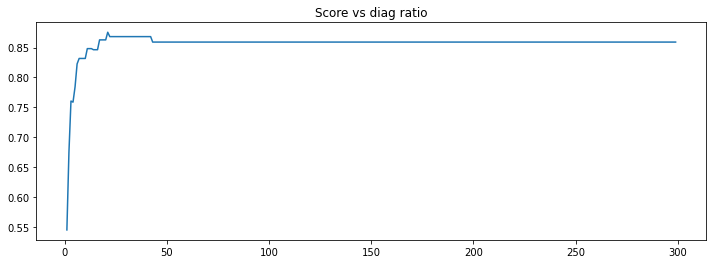

In [166]:
diag_ratios = np.arange(1, 300)

# plot diag_ratio vs score:
scores = []
for d in diag_ratios:
    t = make_trans_prob_matrix(d)
    est = estimate_chords_hmm(t, init_prob, emis_prob, observations)
    s = calc_chord_score(est, ex5_ref)
    scores.append(s)

# find best diag_value
ex10_diag_ratio = diag_ratios[np.argmax(scores, axis=0)]
print(f'best diag ratio={ex10_diag_ratio}')

plt.plot(diag_ratios, scores)
plt.title('Score vs diag ratio')
plt.show()

- How do different values of `diag_ratio` change the behavior of the HMM estimation?
- Why do some values of work better than others?

Answer:
- The `diag_ratio` specifies the probability of chord transitions: the higher it is, the more the HMM model favors chords staying the same.
- Smaller values bring the probability of chord transitions closer to it staying the same, which leads the model to disregard the song's bias towards staying in the same chord for a while. Higher `diag_ratio` values increase the score as they bias the model towards favoring chords staying the same. If `diag_ratio` is too high, however, it can incorrectly lead the model to decide that chords should *never* change.

Finally, set the values of `ex10_best_est` and `ex10_best_score` using the optimal diagonal ratio.

You can then see the score improvements throughout this pset.

In [168]:
t = make_trans_prob_matrix(ex10_diag_ratio)

ex10_best_est = estimate_chords_hmm(t, init_prob, emis_prob, observations)
ex10_best_score = calc_chord_score(ex10_best_est, ex5_ref)

In [169]:
print(f'Initial score:            {ex5_score}')
print(f'With tuned chromagram:    {ex6_score}')
print(f'With smoothed chromagram: {ex7_score}')
print(f'With best HMM estimation: {ex10_best_score}')

Initial score:            0.31992687385740404
With tuned chromagram:    0.5447897623400365
With smoothed chromagram: 0.773308957952468
With best HMM estimation: 0.8756855575868373
